In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import time
import re
from google.colab import drive
from tqdm import tqdm
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
# 设置显示最大列数
pd.set_option('display.max_columns', None)  # None表示不限制
# 设置每列的最大显示宽度（防止换行）
pd.set_option('display.max_colwidth', None)
# 设置显示宽度（字符数）
pd.set_option('display.width', None)

In [ ]:
#mentorship.csv contains mentorship relationships between researchers and has 8 variables: relationship ID (CID), mentee’s person ID, mentor’s person ID, mentorship type, the institution where the
#mentorship happened, institution MAG ID, and the start year and stop year of the interaction.
mentorship=pd.read_csv('/content/drive/MyDrive/academic_tree/data/mentorship.csv')

In [ ]:
#relationship ID (CID),
mentorship
#stop year 最全611925 /743176

,CID,MenteeID,MentorID,MentorshipType,Institution,InstitutionMAGID,StartYear,StopYear
0,2,2,3,1,"University of California, Berkeley",95457486.0,2000,2005
1,3,4,3,2,"University of California, Berkeley",95457486.0,2003,2006
2,5,6,3,1,"University of California, Berkeley",95457486.0,2002,2008
3,6,18761,9,1,"University of California, Berkeley",95457486.0,-1,1984
4,7,10,16,2,"Washington University, Saint Louis",204465549.0,-1,-1
...,...,...,...,...,...,...,...,...
743171,1784798,839679,287445,1,"University of Massachusetts, Amherst",24603500.0,-1,1991
743172,1784800,796638,839680,1,University of Wales,97429440.0,-1,1986
743173,1784802,839681,699264,1,"University of California, Santa Barbara",154570441.0,2017,-1
743174,1784803,699264,38114,1,NaN,NaN,-1,-1


In [ ]:
mentorship=mentorship[ (mentorship['MentorshipType'] == 2)]

In [ ]:
mentorship.shape

(68652, 8)

In [ ]:
mentorship['StartYear'] = mentorship['StartYear'].replace(-1, np.nan)
mentorship['StopYear'] = mentorship['StopYear'].replace(-1, np.nan)

/tmp/ipython-input-7-3891503200.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mentorship['StartYear'] = mentorship['StartYear'].replace(-1, np.nan)
/tmp/ipython-input-7-3891503200.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mentorship['StopYear'] = mentorship['StopYear'].replace(-1, np.nan)


0: Research Assistant（1.9万）

1: Graduate Student（63万，主要类型）

2: Postdoctoral（6.9万）

3: Research Scientist（7,402）

4: Collaborator（1.8万）

时间修补

先保证时间登记的是对的再说
修正时间
存在几个问题

(1)StopYear<StartYear

(2)MenteeID_type1['Diff']=MenteeID_type1.StopYear-MenteeID_type1.StartYear

MenteeID_type1=MenteeID_type1[MenteeID_type1['Diff']<=np.percentile(MenteeID_type1['Diff'], 99.5)]
#也不要一味的删掉，而是看那些异常值。进行修正


In [ ]:
mask=(mentorship['StartYear'] < 1900)| (mentorship['StopYear'] < 1900)
corrections = {1848: 1948, 1889: 1989}
mentorship.loc[mask, 'StartYear'] = mentorship.loc[mask, 'StartYear'].replace(corrections)
mentorship.loc[mask&(mentorship['StopYear'] > 1900)]

,CID,MenteeID,MentorID,MentorshipType,Institution,InstitutionMAGID,StartYear,StopYear
65315,80882,52746,48710,2,"Goldsmiths, University of London",55521800.0,1897.0,1901.0
86371,106378,83157,83156,2,Kaiser-Wilhelms-Universität Straßburg,NaN,1895.0,1905.0
635536,1621596,66719,793111,2,Uniwersytet Jagiello?ski,NaN,1899.0,1901.0
694843,1657099,803459,519702,2,"Michigan State University, PRL",87216513.0,1989.0,1994.0


In [ ]:
mentorship.loc[(mentorship['MentorshipType']==2)&mask&(mentorship['StartYear'] > 1900)]
stop_year_corrections = {
    1895: 1985,
    1873: 1973,
    1886: 1986,
    1012: 2012,
    1879: 1979,
    1006: 1996,
    1078: 1978,
    1001: 1991
}

# 筛选需要修正的行（基于CID）
condition = (mentorship['MentorshipType']==2)&mask&(mentorship['StartYear'] > 1900)
# 应用修正
mentorship.loc[condition, 'StopYear'] = mentorship.loc[condition, 'StopYear'].replace(stop_year_corrections)

In [ ]:
#2 StopYear<StartYear
#mentorship_filtered[mentorship_filtered.StopYear<mentorship_filtered.StartYear]
# 条件筛选
condition = (mentorship['StopYear'] < mentorship['StartYear'])
# 交换内容（保持列名不变）
error_records = mentorship.loc[condition]
mentorship.loc[condition, ['StartYear', 'StopYear']] = mentorship.loc[condition, ['StopYear', 'StartYear']].values

In [ ]:
#3
mentorship['Diff']=mentorship.StopYear-mentorship.StartYear

/tmp/ipython-input-13-2408122321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mentorship['Diff']=mentorship.StopYear-mentorship.StartYear


In [ ]:
np.nanpercentile(mentorship['Diff'], 99)

np.float64(8.0)

In [ ]:
mask = (mentorship["Diff"] <= np.nanpercentile(mentorship['Diff'], 99)) | (mentorship["Diff"].isna())
mentorship=mentorship[mask]

In [ ]:
mentorship.describe()

,CID,MenteeID,MentorID,MentorshipType,InstitutionMAGID,StartYear,StopYear,Diff
count,6.841100e+04,68411.000000,68411.000000,68411.0,4.948200e+04,39594.000000,34824.000000,31163.000000
mean,8.571617e+05,344045.256625,173790.615223,2.0,2.140416e+08,2001.083497,1997.368855,2.618297
std,7.263730e+05,339631.348235,265716.794613,0.0,4.409978e+08,21.527426,28.376453,1.499937
min,3.000000e+00,1.000000,1.000000,2.0,1.972200e+04,1016.000000,1454.000000,0.000000
25%,7.312650e+04,36387.000000,10030.000000,2.0,6.396601e+07,1996.000000,1993.000000,2.000000
50%,1.253716e+06,103368.000000,54221.000000,2.0,1.140272e+08,2007.000000,2006.000000,2.000000
75%,1.558890e+06,744483.500000,133968.000000,2.0,1.613188e+08,2013.000000,2013.000000,3.000000
max,1.784789e+06,839676.000000,839575.000000,2.0,3.045169e+09,2021.000000,2025.000000,8.000000


In [ ]:
resume_df = mentorship.sort_values(['MenteeID', 'StopYear'])

In [ ]:
mentor_stats = (
    resume_df.groupby('MenteeID')['MentorshipType']
    .agg(['count', lambda x: list(x)])  # 使用list而非unique
    .reset_index()
    .rename(columns={'<lambda_0>': 'mentorship_types'})  # 重命名列
)

In [ ]:
mentor_stats

,MenteeID,count,mentorship_types
0,1,1,[2]
1,2,1,[2]
2,3,1,[2]
3,4,2,"[2, 2]"
4,5,1,[2]
...,...,...,...
57493,839662,1,[2]
57494,839663,1,[2]
57495,839668,1,[2]
57496,839674,1,[2]


In [ ]:
mentor_stats['count'].value_counts()

,count
count,
1,48462
2,7527
3,1236
4,210
5,48
6,7
7,4
9,2
11,1


In [ ]:
mentorship_post=mentorship[mentorship.MenteeID.isin(mentor_stats[(mentor_stats['count']==1)|(mentor_stats['count']==2)|(mentor_stats['count']==3)].MenteeID)]

In [ ]:
mentorship_post.describe()

,CID,MenteeID,MentorID,MentorshipType,InstitutionMAGID,StartYear,StopYear,Diff
count,6.722400e+04,67224.000000,67224.000000,67224.0,4.873100e+04,38777.000000,33998.000000,30418.000000
mean,8.590905e+05,344936.815691,173839.935707,2.0,2.141171e+08,2001.301416,1997.705130,2.633145
std,7.260527e+05,339513.331239,265534.801979,0.0,4.411898e+08,21.105367,27.799187,1.502595
min,3.000000e+00,1.000000,1.000000,2.0,1.972200e+04,1016.000000,1454.000000,0.000000
25%,7.343175e+04,36887.000000,10056.000000,2.0,6.396601e+07,1997.000000,1993.000000,2.000000
50%,1.254596e+06,104353.000000,54496.000000,2.0,1.140272e+08,2007.000000,2006.000000,2.000000
75%,1.560038e+06,744589.250000,134938.000000,2.0,1.613188e+08,2013.000000,2013.000000,3.000000
max,1.784789e+06,839676.000000,839575.000000,2.0,3.045169e+09,2021.000000,2025.000000,8.000000


In [ ]:
def fill_academic_years(df):
    """
    分层填充学术阶段时间缺失值（禁用全局统计值填充）
    填充顺序：阶段内连续性填充 → 跨阶段逻辑填充 → 默认学术时长推算
    """
    # 添加填充来源标记列
    df = df.copy()
    df['StartYearSource'] = 'original'
    df['StopYearSource'] = 'original'

    # 按学员分组处理
    grouped = df.groupby('MenteeID')
    filled_dfs = []

    for mentee_id, group in grouped:
        # 分离PhD和Postdoc记录
        postdocs = group[group['MentorshipType'] == 2].copy().sort_values('StartYear')

        # ===== 阶段内连续性填充 (同类型记录间) =====
        # 1.1 填充Postdoc记录间连续性
        if len(postdocs) > 1:
            # 正向填充StartYear (用前段结束年+1)
            for i in range(1, len(postdocs)):
                prev_stop = postdocs.iloc[i-1]['StopYear']
                curr_start = postdocs.iloc[i]['StartYear']
                if pd.isna(curr_start) and not pd.isna(prev_stop):
                    postdocs.iloc[i, postdocs.columns.get_loc('StartYear')] = prev_stop
                    postdocs.iloc[i, postdocs.columns.get_loc('StartYearSource')] = 'intra_phase'

            # 反向填充StopYear (用后段开始年-1)
            for i in range(len(postdocs)-2, -1, -1):
                next_start = postdocs.iloc[i+1]['StartYear']
                curr_stop = postdocs.iloc[i]['StopYear']
                if pd.isna(curr_stop) and not pd.isna(next_start):
                    postdocs.iloc[i, postdocs.columns.get_loc('StopYear')] = next_start
                    postdocs.iloc[i, postdocs.columns.get_loc('StopYearSource')] = 'intra_phase'
        #和PHD retention里面的做法一致，不要擅自改变
        # 3.2 处理Postdoc记录
        for i, postdoc_row in postdocs.iterrows():
            # 单缺失场景：用已知时间推算
            if pd.isna(postdoc_row['StopYear']) and not pd.isna(postdoc_row['StartYear']):
                postdocs.loc[i, 'StopYear'] = postdoc_row['StartYear'] + 3
                postdocs.loc[i, 'StopYearSource'] = 'duration_infer'
            elif pd.isna(postdoc_row['StartYear']) and not pd.isna(postdoc_row['StopYear']):
                postdocs.loc[i, 'StartYear'] = postdoc_row['StopYear'] - 3
                postdocs.loc[i, 'StartYearSource'] = 'duration_infer'
        filled_dfs.append(postdocs)

    # 合并结果
    result_df = pd.concat(filled_dfs)
    return result_df
# ===== 执行填充 =====
filled_df = fill_academic_years(mentorship_post)
# ===== 验证与统计 =====
# 1. 检查残留缺失值
missing_after = filled_df[['StartYear', 'StopYear']].isnull().sum()
print(f"填充后缺失值统计:\nStartYear: {missing_after[0]}, StopYear: {missing_after[1]}")
# 2. 查看填充来源分布
print("\n填充来源分布:")
print(filled_df[['StartYearSource', 'StopYearSource']].apply(pd.Series.value_counts))


填充后缺失值统计:
StartYear: 24113, StopYear: 24113

填充来源分布:
                StartYearSource  StopYearSource
original                  62890           58111
duration_infer             3054            8538
intra_phase                1280             575


/tmp/ipython-input-41-2785247398.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"填充后缺失值统计:\nStartYear: {missing_after[0]}, StopYear: {missing_after[1]}")


In [ ]:
filled_df.StartYearSource.value_counts()

,count
StartYearSource,
original,62890
duration_infer,3054
intra_phase,1280


In [ ]:
filled_df.StopYearSource.value_counts()

,count
StopYearSource,
original,58111
duration_infer,8538
intra_phase,575


In [ ]:
filled_df.describe()

,CID,MenteeID,MentorID,MentorshipType,InstitutionMAGID,StartYear,StopYear,Diff
count,6.722400e+04,67224.000000,67224.000000,67224.0,4.873100e+04,43111.000000,43111.000000,30418.000000
mean,8.590905e+05,344936.815691,173839.935707,2.0,2.141171e+08,1998.675837,2001.374986,2.633145
std,7.260527e+05,339513.331239,265534.801979,0.0,4.411898e+08,26.387154,26.123871,1.502595
min,3.000000e+00,1.000000,1.000000,2.0,1.972200e+04,1016.000000,1454.000000,0.000000
25%,7.343175e+04,36887.000000,10056.000000,2.0,6.396601e+07,1994.000000,1997.000000,2.000000
50%,1.254596e+06,104353.000000,54496.000000,2.0,1.140272e+08,2006.000000,2009.000000,2.000000
75%,1.560038e+06,744589.250000,134938.000000,2.0,1.613188e+08,2013.000000,2015.000000,3.000000
max,1.784789e+06,839676.000000,839575.000000,2.0,3.045169e+09,2021.000000,2025.000000,8.000000


In [ ]:
# 找出StartYear和StopYear都为空的记录
empty_years = filled_df[filled_df['StartYear'].isnull() & filled_df['StopYear'].isnull()]

# 查看结果
print(f"双字段缺失的记录数: {len(empty_years)}")
empty_years[['MenteeID', 'MentorshipType', 'StartYear', 'StopYear']].head()

双字段缺失的记录数: 24113


,MenteeID,MentorshipType,StartYear,StopYear
5,3,2,NaN,NaN
4,10,2,NaN,NaN
1822,10,2,NaN,NaN
1823,10,2,NaN,NaN
133,11,2,NaN,NaN


In [ ]:
# 获取empty_years中的所有MenteeID
ids_to_remove = empty_years['MenteeID'].unique()

# 从filled_df中排除这些ID
filtered_df = filled_df[~filled_df['MenteeID'].isin(ids_to_remove)]

# 验证结果
print(f"原始记录数: {len(filled_df)}")
print(f"过滤后记录数: {len(filtered_df)}")
print(f"移除记录数: {len(filled_df) - len(filtered_df)}")

原始记录数: 67224
过滤后记录数: 42694
移除记录数: 24530


In [ ]:
filtered_df.describe()

,CID,MenteeID,MentorID,MentorshipType,InstitutionMAGID,StartYear,StopYear,Diff
count,4.269400e+04,42694.000000,42694.000000,42694.0,3.252700e+04,42694.000000,42694.000000,30356.000000
mean,8.961511e+05,359670.109570,178038.615590,2.0,2.088623e+08,1998.635405,2001.332482,2.633153
std,7.198420e+05,339433.964398,264442.876687,0.0,4.288910e+08,26.440120,26.175429,1.503028
min,3.000000e+00,1.000000,1.000000,2.0,1.972200e+04,1016.000000,1454.000000,0.000000
25%,8.505550e+04,55244.500000,13915.000000,2.0,6.396601e+07,1994.000000,1997.000000,2.000000
50%,1.291658e+06,134041.500000,56999.000000,2.0,1.140272e+08,2006.000000,2009.000000,2.000000
75%,1.571598e+06,749977.500000,151595.750000,2.0,1.613188e+08,2013.000000,2015.000000,3.000000
max,1.784774e+06,839668.000000,839575.000000,2.0,3.045169e+09,2021.000000,2025.000000,8.000000


In [ ]:
filtered_df.Diff.mean()

np.float64(2.6331532481222824)

In [ ]:
filtered_df['Diff']=filtered_df.StopYear-filtered_df.StartYear

/tmp/ipython-input-84-2515788923.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Diff']=filtered_df.StopYear-filtered_df.StartYear


In [ ]:
mask = (filtered_df["Diff"] <= np.nanpercentile(filtered_df['Diff'], 99))&(filtered_df["Diff"] > 0)
filtered_df=filtered_df[mask]

In [ ]:
filtered_df.describe()

,CID,MenteeID,MentorID,MentorshipType,InstitutionMAGID,StartYear,StopYear,Diff
count,4.113100e+04,41131.000000,41131.000000,41131.0,3.140800e+04,41131.000000,41131.000000,41131.000000
mean,8.965902e+05,360363.293963,178082.953587,2.0,2.093731e+08,1998.831222,2001.574895,2.743673
std,7.197346e+05,339310.908870,264206.931312,0.0,4.297420e+08,25.492941,25.632508,1.208191
min,3.000000e+00,1.000000,1.000000,2.0,1.972200e+04,1451.000000,1454.000000,1.000000
25%,8.507350e+04,55586.000000,14178.000000,2.0,6.396601e+07,1994.000000,1997.000000,2.000000
50%,1.291476e+06,135893.000000,57030.000000,2.0,1.140272e+08,2006.000000,2009.000000,3.000000
75%,1.571718e+06,750240.000000,152410.000000,2.0,1.613188e+08,2013.000000,2015.000000,3.000000
max,1.784774e+06,839668.000000,839575.000000,2.0,3.045169e+09,2021.000000,2025.000000,7.000000


In [ ]:
filtered_df=filtered_df[(filtered_df.StopYear<=2015)&(filtered_df.StopYear>=1900)]

In [ ]:
filtered_df

,CID,MenteeID,MentorID,MentorshipType,Institution,InstitutionMAGID,StartYear,StopYear,Diff,StartYearSource,StopYearSource
308,346,1,184,2,"University of Maryland, College Park",66946132.0,2005.0,2012.0,7.0,original,original
1102,1256,2,72,2,Duke University,170897317.0,2005.0,2011.0,6.0,original,original
1,3,4,3,2,"University of California, Berkeley",95457486.0,2003.0,2006.0,3.0,original,original
8015,9624,4,788,2,University of Oxford,40120149.0,2006.0,2009.0,3.0,original,duration_infer
31020,38845,5,312,2,Stanford University,97018004.0,2009.0,2013.0,4.0,original,original
...,...,...,...,...,...,...,...,...,...,...,...
743113,1784658,839640,594443,2,Illinois State University,47301684.0,2006.0,2009.0,3.0,duration_infer,original
743114,1784660,839641,594443,2,Illinois State University,47301684.0,2001.0,2004.0,3.0,duration_infer,original
743125,1784686,839647,51853,2,Princeton University,20089843.0,1928.0,1931.0,3.0,duration_infer,original
743135,1784716,839657,64574,2,Stanford University,97018004.0,1979.0,1981.0,2.0,original,original


In [ ]:
filtered_df.drop(['StartYearSource','StopYearSource'],axis=1,inplace=True)

In [ ]:
#mentorship.csv contains mentorship relationships between researchers and has 8 variables: relationship ID (CID), mentee’s person ID, mentor’s person ID, mentorship type, the institution where the
#mentorship happened, institution MAG ID, and the start year and stop year of the interaction.
mentorship=pd.read_csv('/content/drive/MyDrive/academic_tree/data/mentorship.csv')

In [ ]:
mentor_list=mentorship['MentorID'].unique()

In [ ]:
len(mentor_list)

189604

In [ ]:
filtered_df.loc[filtered_df['MenteeID'].isin(mentor_list),'retention']=1

In [ ]:
filtered_df

,CID,MenteeID,MentorID,MentorshipType,Institution,InstitutionMAGID,StartYear,StopYear,Diff,retention
308,346,1,184,2,"University of Maryland, College Park",66946132.0,2005.0,2012.0,7.0,1.0
1102,1256,2,72,2,Duke University,170897317.0,2005.0,2011.0,6.0,1.0
1,3,4,3,2,"University of California, Berkeley",95457486.0,2003.0,2006.0,3.0,1.0
8015,9624,4,788,2,University of Oxford,40120149.0,2006.0,2009.0,3.0,1.0
31020,38845,5,312,2,Stanford University,97018004.0,2009.0,2013.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...
743113,1784658,839640,594443,2,Illinois State University,47301684.0,2006.0,2009.0,3.0,NaN
743114,1784660,839641,594443,2,Illinois State University,47301684.0,2001.0,2004.0,3.0,NaN
743125,1784686,839647,51853,2,Princeton University,20089843.0,1928.0,1931.0,3.0,NaN
743135,1784716,839657,64574,2,Stanford University,97018004.0,1979.0,1981.0,2.0,NaN


In [ ]:
latest_pubs=pd.read_csv("/content/drive/MyDrive/academic_tree/data/latest_pub/latest_publications_by_PID.csv")

In [ ]:
ealier_pubs=pd.read_csv("/content/drive/MyDrive/academic_tree/data/latest_pub/ealier_publications_by_PID.csv")

In [ ]:
Retention.to_csv('/content/drive/MyDrive/academic_tree/postdta.csv',index=False)

In [ ]:
Retention=filtered_df.merge(
    latest_pubs,
    left_on="MenteeID",
    right_on="PID",
    how='left'
    )

In [ ]:
# 创建布尔掩码：检查最新出版年份与停止年份的差值是否大于等于10
mask = (Retention['Latest_Publication_Year'] - Retention['StopYear']) >= 5

# 使用 loc 根据掩码条件为符合条件的行设置 retention2 列的值为1
Retention.loc[mask, 'retention2'] = 1

In [ ]:
Retention[['retention','retention2']]=Retention[['retention','retention2']].fillna(0)

In [ ]:
Retention[['retention','retention2']].corr()

,retention,retention2
retention,1.000000,0.368356
retention2,0.368356,1.000000


In [ ]:
Retention[['retention','retention2']].describe()

,retention,retention2
count,30421.000000,30421.000000
mean,0.523356,0.767989
std,0.499462,0.422123
min,0.000000,0.000000
25%,0.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [ ]:
Retention.to_csv('/content/drive/MyDrive/academic_tree/results/postdoc_retention.csv',index=False)

开始了

In [3]:
Retention_=pd.read_csv('/content/drive/MyDrive/academic_tree/results/postdoc_retention.csv')

In [4]:
Retention_.columns

Index(['CID', 'MenteeID', 'MentorID', 'MentorshipType', 'InstitutionMAGID',
       'StartYear', 'StopYear', 'Diff', 'retention', 'retention2',
       'MenteepostdocPapers', 'MenteePublishedPapersbefore',
       'MenteePaperscountbefore', 'MentorPublishedPapersbefore',
       'MentorPublishedPapersduring', 'OverlapCountduring',
       'menteepaperscount_d', 'MentorPapersduringcount',
       'MenteeColduringRatio', 'MentorColduringRatio', 'mentee_similarity_nor',
       'mentor_similarity_nor', 'cross_similarity_nor', 'Citation_Count',
       'C10', 'C5', 'Team_Size', 'Institution_Count', 'Disruption',
       'NIH_Count', 'NSF_Count', 'Atyp_10pct_Z', 'Atyp_Median_Z',
       'Patent_Count', 'SB_B', 'SB_T', 'Reference_Count',
       'mentorpaperscount_b', 'mentor_citation_count_b', 'mentor_team_size_b',
       'mentee_citation_count_before', 'ResearchArea', 'MAGAuthorID', 'gender',
       'race', 'JSD', 'JSD_sub', 'JSD_before', 'Hit_1pct_max', 'Hit_5pct_max',
       'Hit_10pct_max', 'C_f_m

In [2]:
'''
MAG_paper=pd.read_csv('/content/drive/MyDrive/academic_tree/data/Scinet/MAGpaper.csv')
MAG_paper.rename({'PaperID':'MAGPaperID'},axis=1,inplace=True)
authorship=pd.read_csv('/content/drive/MyDrive/academic_tree/data/authorship.csv')
print(authorship.shape,len(authorship.MAGPaperID.unique()))
authorship=authorship.merge(MAG_paper,on=['MAGPaperID'])
print(authorship.shape,len(authorship.MAGPaperID.unique()))
authorship=authorship.drop(['Newsfeed_Count', 'Tweet_Count', 'NCT_Count', 'DOI', 'Date', 'DocType', 'JournalID', 'ConferenceSeriesID','WSB_mu','WSB_sigma','WSB_Cinf'],axis=1)
authorship.to_csv('/content/drive/MyDrive/academic_tree/data/iterme/authorship_metrics.csv',index=False)
'''
authorship=pd.read_csv('/content/drive/MyDrive/academic_tree/data/iterme/authorship_metrics.csv')

In [ ]:
# 筛选Mentee在postdoc学术阶段内发表的论文
merged_mentee = pd.merge(
    Retention,
    authorship,
    left_on='MenteeID',
    right_on='PID',
)
merge=merged_mentee.copy()

valid_papers = merge[
    (
        (~merge['StartYear'].isna()) &
        (merge['Year'] > merge['StartYear']) &
        (merge['Year'] <= merge['StopYear']+2)
    ) |
    (
        merge['StartYear'].isna() &
        (merge['Year'] > merge['StopYear'] - 3) &
        (merge['Year'] <= merge['StopYear']+2)
    )
]
paper_lists = valid_papers.groupby('CID')['MAGPaperID'].apply(list).reset_index()
paper_lists.columns = ['CID', 'MenteepostdocPapers']
Retention_ = pd.merge(Retention, paper_lists, on='CID', how='left')
Retention_['MenteepostdocPapers'] = Retention_['MenteepostdocPapers'].apply(lambda x: x if isinstance(x, list) else [])

In [ ]:
merged_mentee = pd.merge(
    Retention_,
    authorship,
    left_on='MenteeID',
    right_on='PID',
)
merge=merged_mentee.copy()
valid_papers = merge[
    (
        (~merge['StartYear'].isna()) &
        (merge['Year'] >= merge['StartYear']-3) &
        (merge['Year'] < merge['StartYear'])
    ) |
    (
        merge['StartYear'].isna() &
        (merge['Year'] >= merge['StopYear'] - 6) &
        (merge['Year'] < merge['StopYear']-3)
    )
]
paper_lists = valid_papers.groupby('CID')['MAGPaperID'].apply(list).reset_index()
paper_lists.columns = ['CID', 'MenteePublishedPapersbefore']
Retention_ = pd.merge(Retention_, paper_lists, on='CID', how='left')
# 空列表填充为NaN（可选）
Retention_['MenteePublishedPapersbefore'] = Retention_['MenteePublishedPapersbefore'].apply(lambda x: x if isinstance(x, list) else [])
Retention_['MenteePaperscountbefore'] = Retention_['MenteePublishedPapersbefore'].apply(len)

In [ ]:
Retention_[['MenteePaperscountbefore','MenteePublishedPapersbefore']]

,MenteePaperscountbefore,MenteePublishedPapersbefore
0,3,"[2061209400, 2076398027, 2170556807]"
1,1,[2165789639]
2,0,[]
3,1,[2121693165]
4,4,"[1967303766, 2007226897, 2008402640, 2114000517]"
...,...,...
30416,3,"[1969207777, 2100564743, 2145099556]"
30417,6,"[1974314035, 1989055175, 2023744313, 2087265655, 2148333671, 2152677522]"
30418,0,[]
30419,0,[]


In [ ]:
# 筛选Mentor在学生读postdoc之前发表的论文
merged_mentor = pd.merge(
    Retention_,
    authorship,
    left_on='MentorID',
    right_on='PID',
)
merge=merged_mentor
valid_papers = merge[
    (
        (~merge['StartYear'].isna()) &
        (merge['Year'] >= merge['StartYear']-3) &
        (merge['Year'] < merge['StartYear'])
    ) |
    (
        merge['StartYear'].isna() &
        (merge['Year'] >= merge['StopYear'] - 6) &
        (merge['Year'] < merge['StopYear']-3)
    )
]
paper_lists = valid_papers.groupby('CID')['MAGPaperID'].apply(list).reset_index()
paper_lists.columns = ['CID', 'MentorPublishedPapersbefore']
Retention_ = pd.merge(Retention_, paper_lists, on='CID', how='left')
Retention_['MentorPublishedPapersbefore'] = Retention_['MentorPublishedPapersbefore'].apply(lambda x: x if isinstance(x, list) else [])

In [5]:
# 筛选Mentor在学生读postdoc之前发表的论文 (t-5,t)
merged_mentor = pd.merge(
    Retention_,
    authorship,
    left_on='MentorID',
    right_on='PID',
)
merge=merged_mentor
valid_papers = merge[
    (
        (~merge['StartYear'].isna()) &
        (merge['Year'] >= merge['StartYear']-5) &
        (merge['Year'] < merge['StartYear'])
    ) |
    (
        merge['StartYear'].isna() &
        (merge['Year'] >= merge['StopYear'] - 8) &
        (merge['Year'] < merge['StopYear']-3)
    )
]
paper_lists = valid_papers.groupby('CID')['MAGPaperID'].apply(list).reset_index()
paper_lists.columns = ['CID', 'MentorPublishedPapers_5']
Retention_ = pd.merge(Retention_, paper_lists, on='CID', how='left')
Retention_['MentorPublishedPapers_5'] = Retention_['MentorPublishedPapers_5'].apply(lambda x: x if isinstance(x, list) else [])

In [ ]:
# 筛选Mentor在自己学生mentee读postdoc的时候发表的论文
merged_mentor = pd.merge(
    Retention_,
    authorship,
    left_on='MentorID',
    right_on='PID',
)
merge=merged_mentor
valid_papers = merge[
    (
        (~merge['StartYear'].isna()) &
        (merge['Year'] >= merge['StartYear']) &
        (merge['Year'] <= merge['StopYear']+2)
    ) |
    (
        merge['StartYear'].isna() &
        (merge['Year'] >= merge['StopYear'] - 3) &
        (merge['Year'] <= merge['StopYear'] + 2)
    )
]
paper_lists = valid_papers.groupby('CID')['MAGPaperID'].apply(list).reset_index()
paper_lists.columns = ['CID', 'MentorPublishedPapersduring']
# 合并回原表
Retention_ = pd.merge(Retention_, paper_lists, on='CID', how='left')
# 空列表填充为NaN（可选）
Retention_['MentorPublishedPapersduring'] = Retention_['MentorPublishedPapersduring'].apply(lambda x: x if isinstance(x, list) else [])

Retention_['OverlapCountduring'] = Retention_.apply(lambda row: len(set(row['MenteepostdocPapers']) & set(row['MentorPublishedPapersduring'])),axis=1)
Retention_['MenteePapersduringcount'] = Retention_['MenteepostdocPapers'].apply(len)
Retention_['MentorPapersduringcount'] = Retention_['MentorPublishedPapersduring'].apply(len)

Retention_['MenteeColduringRatio'] = Retention_['OverlapCountduring'] / Retention_['MenteePapersduringcount']
# 计算 Mentor 视角的重合比例
Retention_['MentorColduringRatio'] = Retention_['OverlapCountduring'] / Retention_['MentorPapersduringcount']
# 处理除零错误（如果 MenteePapersCount 或 MentorPapersCount 为 0）
Retention_['MenteeColduringRatio'] = Retention_['MenteeColduringRatio'].fillna(0)
Retention_['MentorColduringRatio'] = Retention_['MentorColduringRatio'].fillna(0)

In [ ]:
# StopYear没有缺失的
#1-4年MenteefurtherrPapers1_4
#4-7年MenteefurtherrPapers4_7
#7-10年MenteefurtherrPapers7_10
merged_mentor = pd.merge(
    Retention_[['CID','MenteeID','StartYear','StopYear']],
    authorship,
    left_on='MenteeID',
    right_on='PID',
)
merge=merged_mentor
valid_papers = merge[((merge['Year'] >= merge['StopYear']+7) & (merge['Year'] <= merge['StopYear']+10)) ]
paper_lists = valid_papers.groupby('CID')['MAGPaperID'].apply(list).reset_index()
paper_lists.columns = ['CID', 'MenteefurtherrPapers7_10']
# 合并回原表
Retention_ = pd.merge(Retention_, paper_lists, on='CID', how='left')
# 空列表填充为NaN（可选）
Retention_['MenteefurtherrPapers7_10'] = Retention_['MenteefurtherrPapers7_10'].apply(lambda x: x if isinstance(x, list) else [])
Retention_['MenteefurtherrPaperscount7_10']=Retention_['MenteefurtherrPapers7_10'].apply(len)

In [6]:
Retention_.columns

Index(['CID', 'MenteeID', 'MentorID', 'MentorshipType', 'InstitutionMAGID',
       'StartYear', 'StopYear', 'Diff', 'retention', 'retention2',
       'MenteepostdocPapers', 'MenteePublishedPapersbefore',
       'MenteePaperscountbefore', 'MentorPublishedPapersbefore',
       'MentorPublishedPapersduring', 'OverlapCountduring',
       'menteepaperscount_d', 'MentorPapersduringcount',
       'MenteeColduringRatio', 'MentorColduringRatio', 'mentee_similarity_nor',
       'mentor_similarity_nor', 'cross_similarity_nor', 'Citation_Count',
       'C10', 'C5', 'Team_Size', 'Institution_Count', 'Disruption',
       'NIH_Count', 'NSF_Count', 'Atyp_10pct_Z', 'Atyp_Median_Z',
       'Patent_Count', 'SB_B', 'SB_T', 'Reference_Count',
       'mentorpaperscount_b', 'mentor_citation_count_b', 'mentor_team_size_b',
       'mentee_citation_count_before', 'ResearchArea', 'MAGAuthorID', 'gender',
       'race', 'JSD', 'JSD_sub', 'JSD_before', 'Hit_1pct_max', 'Hit_5pct_max',
       'Hit_10pct_max', 'C_f_m

In [ ]:
import pandas as pd

# 1. 确定 StopYear 的范围
max_year = int(valid_rows['StopYear'].max())

# 2. 创建 10 年分组
bins = list(range(1900, max_year + 10, 10))
labels = [f"{start}-{start+10}" for start in bins[:-1]]

valid_rows['YearGroup'] = pd.cut(
    valid_rows['StopYear'],
    bins=bins,
    labels=labels,
    right=False
)

# 3. 计算每组的论文数量均值
valid_rows['PaperCount'] = valid_rows['PublishedPapers'].apply(len)
result = valid_rows.groupby('YearGroup')['PaperCount'].mean().reset_index()
result.columns = ['YearRange', 'AvgPaperCount']

print(result)

    YearRange  AvgPaperCount
0   1900-1910      13.930380
1   1910-1920      12.341121
2   1920-1930      14.515658
3   1930-1940      14.582451
4   1940-1950      12.440748
5   1950-1960      13.067836
6   1960-1970      13.511966
7   1970-1980      17.573074
8   1980-1990      22.009588
9   1990-2000      27.487990
10  2000-2010      25.796418
11  2010-2020      31.743736


<ipython-input-19-1523066550>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_rows['YearGroup'] = pd.cut(
<ipython-input-19-1523066550>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_rows['PaperCount'] = valid_rows['PublishedPapers'].apply(len)
<ipython-input-19-1523066550>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and si

In [ ]:
Retention_.describe()

,CID,MenteeID,MentorID,MentorshipType,InstitutionMAGID,StartYear,StopYear,Diff,retention,PID,Latest_Publication_Year,retention2,MenteePaperscountbefore,OverlapCountduring,MenteePapersduringcount,MentorPapersduringcount,MenteeColduringRatio,MentorColduringRatio
count,3.042100e+04,30421.000000,30421.000000,30421.0,2.375500e+04,30421.000000,30421.000000,30421.000000,30421.000000,27559.000000,27559.000000,30421.000000,30421.000000,30421.000000,30421.000000,30421.000000,30421.000000,30421.000000
mean,7.440583e+05,297788.486276,153600.447290,2.0,2.076855e+08,1995.505407,1998.189343,2.683935,0.523356,287227.627091,2015.877173,0.767989,2.627922,3.324546,8.330200,47.840505,0.344681,0.080943
std,7.185394e+05,322832.989165,245056.681697,0.0,4.272968e+08,18.598145,18.770104,1.258058,0.499462,318376.946595,10.055873,0.422123,4.635233,5.224836,12.017536,52.469153,0.351842,0.115847
min,3.000000e+00,1.000000,1.000000,2.0,2.417490e+05,1897.000000,1900.000000,1.000000,0.000000,1.000000,1899.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.784100e+04,35499.000000,12025.000000,2.0,6.396601e+07,1990.000000,1993.000000,2.000000,0.000000,32866.000000,2016.000000,1.000000,0.000000,0.000000,2.000000,16.000000,0.000000,0.000000
50%,2.351510e+05,92545.000000,55526.000000,2.0,1.140272e+08,2002.000000,2005.000000,3.000000,1.000000,86993.000000,2020.000000,1.000000,1.000000,2.000000,6.000000,33.000000,0.250000,0.039216
75%,1.506383e+06,690957.000000,92752.000000,2.0,1.613188e+08,2008.000000,2011.000000,3.000000,1.000000,679468.000000,2020.000000,1.000000,4.000000,5.000000,11.000000,62.000000,0.625000,0.117647
max,1.784774e+06,839668.000000,839575.000000,2.0,3.020458e+09,2014.000000,2015.000000,7.000000,1.000000,839647.000000,2022.000000,1.000000,163.000000,176.000000,462.000000,977.000000,1.000000,1.000000


In [7]:
Retention_.to_csv('/content/drive/MyDrive/academic_tree/results/postdoc_retention.csv',index=False)

In [ ]:
valid_rows=Retention_[Retention_['PublishedPapers'].str.len() > 0]

In [ ]:
valid_rows.describe()

,CID,MenteeID,MentorID,MentorshipType,InstitutionMAGID,StartYear,StopYear,Diff,retention,PID,Latest_Publication_Year,retention2
count,3.136540e+05,313654.000000,313654.000000,313654.0,3.027250e+05,21152.000000,313654.000000,21152.000000,313654.000000,205801.000000,205801.000000,313654.000000
mean,7.769506e+05,381861.927487,334888.116023,1.0,1.194974e+08,1993.792124,2002.869904,4.531534,0.098283,369629.438229,2012.475348,0.283475
std,4.166498e+05,211914.061414,215559.731596,0.0,1.493221e+08,12.926908,11.040572,1.469642,0.297698,222391.355146,8.738287,0.450686
min,1.000000e+00,1.000000,3.000000,1.0,2.417490e+05,1858.000000,1801.000000,0.000000,0.000000,1.000000,1888.000000,0.000000
25%,4.398365e+05,200745.250000,174209.000000,1.0,6.319074e+07,1988.000000,2002.000000,4.000000,0.000000,161168.000000,2007.000000,0.000000
50%,7.709000e+05,376092.500000,335566.000000,1.0,1.076392e+08,1998.000000,2005.000000,5.000000,0.000000,373640.000000,2014.000000,0.000000
75%,1.082584e+06,548676.000000,516101.750000,1.0,1.545704e+08,2003.000000,2009.000000,5.000000,0.000000,544201.000000,2020.000000,1.000000
max,1.784798e+06,839679.000000,839678.000000,1.0,3.045169e+09,2011.000000,2011.000000,9.000000,1.000000,839679.000000,2022.000000,1.000000


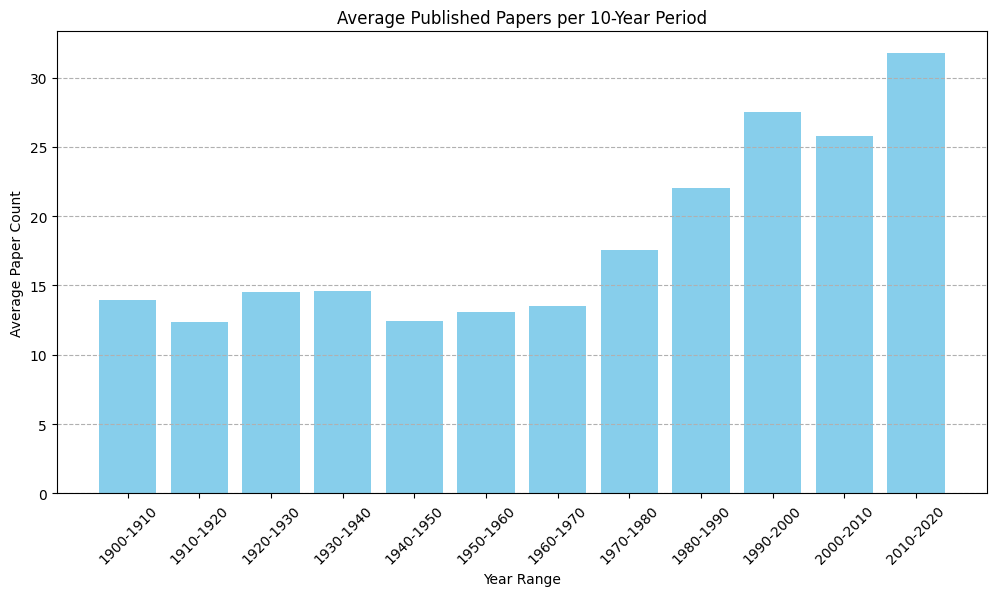

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 计算10年分组和论文数量（假设已按之前方法生成result表）
plt.figure(figsize=(12, 6))
plt.bar(result['YearRange'], result['AvgPaperCount'], color='skyblue')
plt.xlabel('Year Range')
plt.ylabel('Average Paper Count')
plt.title('Average Published Papers per 10-Year Period')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

查看coauthor的数量

In [ ]:
Retention_=pd.read_csv('/content/drive/MyDrive/academic_tree/results/postdoc_retention.csv')

In [ ]:
Retention_['MentorPaperscount_b'] = Retention_['MentorPublishedPapersbefore'].apply(len)

In [ ]:
Retention_.columns

Index(['CID', 'MenteeID', 'MentorID', 'MentorshipType', 'InstitutionMAGID',
       'StartYear', 'StopYear', 'Diff', 'retention', 'retention2',
       'MenteepostdocPapers', 'MenteePublishedPapersbefore',
       'MenteePaperscountbefore', 'MentorPublishedPapersbefore',
       'MentorPublishedPapersduring', 'OverlapCountduring',
       'menteepaperscount_d', 'MentorPapersduringcount',
       'MenteeColduringRatio', 'MentorColduringRatio', 'mentee_similarity_nor',
       'mentor_similarity_nor', 'cross_similarity_nor', 'Citation_Count',
       'C10', 'C5', 'Team_Size', 'Institution_Count', 'Disruption',
       'NIH_Count', 'NSF_Count', 'Atyp_10pct_Z', 'Atyp_Median_Z',
       'Patent_Count', 'SB_B', 'SB_T', 'Reference_Count',
       'mentorpaperscount_b', 'mentor_citation_count_b', 'mentor_team_size_b',
       'mentee_citation_count_before', 'ResearchArea', 'MAGAuthorID', 'gender',
       'race', 'JSD', 'JSD_sub', 'JSD_before', 'Hit_1pct_max', 'Hit_5pct_max',
       'Hit_10pct_max', 'C_f_m

In [ ]:
import ast
def safe_convert(x):
    if isinstance(x, list):  # 已经是列表，直接返回
        return x
    elif isinstance(x, str):  # 如果是字符串，尝试解析
        try:
            return ast.literal_eval(x)
        except:
            return []  # 解析失败则返回空列表
    else:  # 其他情况（如 NaN、数字等）
        return []
Retention_['MenteepostdocPapers'] = Retention_['MenteepostdocPapers'].apply(safe_convert)
Retention_['MenteePublishedPapersbefore']= Retention_['MenteePublishedPapersbefore'].apply(safe_convert)
Retention_['MentorPublishedPapersbefore'] = Retention_['MentorPublishedPapersbefore'].apply(safe_convert)
Retention_['MentorPublishedPapersduring']= Retention_['MentorPublishedPapersduring'].apply(safe_convert)

In [ ]:
from scipy import sparse
data = np.load('/content/drive/MyDrive/academic_tree/data/tfidf/paper_tfidf.npz')
tfidf_csr = sparse.csr_matrix(
    (data['data'], data['indices'], data['indptr']),
    shape=data['shape']
)

paper_tfidf_MAGPaperID = pd.read_csv(
    '/content/drive/MyDrive/academic_tree/data/tfidf/paper_tfidf_MAGPaperID.txt',
    compression='gzip',
    header=None,  # 无列名
    names=['MAGPaperID']  # 自定义列名
)
paper_id_mapping = paper_tfidf_MAGPaperID.to_dict()  # {索引: 值}
reversed_dict = {v: k for k, v in paper_id_mapping['MAGPaperID'].items()}

In [ ]:
def normalize_vector(vec):
    """归一化单个向量"""
    if isinstance(vec, sparse.csr_matrix):
        # 处理稀疏向量
        norm = np.linalg.norm(vec.data)
        if norm > 0:
            return vec / norm
        return vec
    else:
        # 处理密集向量
        norm = np.linalg.norm(vec)
        if norm > 0:
            return vec / norm
        return vec

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def get_paper_indices(paper_ids):
    return [reversed_dict[pid] for pid in paper_ids]
def calc_phase_similarity(paper_list):
    """计算一个阶段论文集合的余弦相似度均值"""
    if len(paper_list) < 2:
        return np.nan  # 不足2篇无法计算
    indices = get_paper_indices(paper_list)
    vectors = tfidf_csr[indices]
    normalized_vectors = []
    for vec in vectors:
        normalized_vectors.append(normalize_vector(vec))
    if isinstance(vectors, sparse.csr_matrix):
        normalized_vectors = sparse.vstack(normalized_vectors)
    # 计算全连接相似度矩阵
    #sim_matrix = cosine_similarity(vectors)
    sim_matrix = cosine_similarity(normalized_vectors)
    return np.tril(sim_matrix, k=-1).sum() / (len(paper_list)*(len(paper_list)-1)/2)

from tqdm import tqdm
Retention_['mentee_similarity_nor'] = [calc_phase_similarity(papers) for papers in tqdm(Retention_['MenteepostdocPapers'])]
# 自定义进度条外观
Retention_['mentor_similarity_nor'] = [calc_phase_similarity(papers) for papers in tqdm(Retention_['MentorPublishedPapersbefore'])]

from sklearn.preprocessing import normalize
from tqdm import tqdm
def calc_cross_similarity(mentee_ids, mentor_ids):
    # 获取有效论文的索引
    phd_indices = [reversed_dict[pid] for pid in mentee_ids]
    postdoc_indices = [reversed_dict[pid] for pid in mentor_ids]

    if not phd_indices or not postdoc_indices:
        return np.nan
    phd_vectors = normalize(tfidf_csr[phd_indices], norm='l2', axis=1)
    postdoc_vectors = normalize(tfidf_csr[postdoc_indices], norm='l2', axis=1)

    # 计算跨列表相似度矩阵
    sim_matrix = phd_vectors.dot(postdoc_vectors.T)
    return  sim_matrix.mean()

from tqdm.notebook import tqdm  # 使用Jupyter风格的进度条
import pandas as pd
def apply_with_progress(df, func, axis=1, desc="Processing"):
    tqdm.pandas(desc=desc, leave=False)  # leave=False表示完成后不保留进度条
    return df.progress_apply(func, axis=axis)
print("开始计算跨列表相似度...")
Retention_['cross_similarity_nor'] = apply_with_progress(
    Retention_,
    lambda row: calc_cross_similarity(row['MenteepostdocPapers'], row['MentorPublishedPapersbefore']),
    desc="计算跨列表相似度"
)

100%|██████████| 30421/30421 [01:48<00:00, 281.27it/s]
计算相似度: 100%|██████████| 30421/30421

开始计算跨列表相似度...


计算跨列表相似度:   0%|          | 0/30421 [00:00<?, ?it/s]

In [ ]:
Retention_.to_csv('/content/drive/MyDrive/academic_tree/results/postdoc_retention.csv',index=False)

In [ ]:
authorship

,PID,MAGPaperID,Year,Citation_Count,C10,Reference_Count,C5,Team_Size,Institution_Count,Disruption,Atyp_10pct_Z,Atyp_Pairs,Atyp_Median_Z,SB_B,SB_T,Patent_Count,NIH_Count,NSF_Count
0,1,1519578210,2015.0,383.0,NaN,57.0,304.0,3.0,2.0,-0.016115,-1.587336,334.0,162.543790,-1.253290,2.0,0,4,0
1,1,1972926514,2012.0,38.0,NaN,5.0,6.0,2.0,2.0,-0.013774,-27.872626,3.0,-10.887451,10.500000,4.0,1,0,0
2,1,1981764347,2009.0,111.0,83.0,47.0,26.0,4.0,1.0,-0.000531,-2.657346,218.0,98.822970,2.250000,9.0,2,4,0
3,1,1982956265,2008.0,128.0,102.0,53.0,39.0,4.0,1.0,-0.004891,-3.622292,221.0,206.024601,3.510921,8.0,0,1,0
4,1,1990434553,2008.0,6.0,5.0,0.0,3.0,4.0,1.0,NaN,NaN,NaN,NaN,1.000000,1.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22195044,839680,2476168493,2008.0,1.0,1.0,171.0,1.0,5.0,NaN,-0.000058,NaN,NaN,NaN,NaN,NaN,0,0,0
22195045,839680,2494182827,1995.0,1.0,1.0,14.0,1.0,5.0,NaN,-0.000869,NaN,NaN,NaN,NaN,NaN,0,0,0
22195046,839680,2899949966,2019.0,3.0,NaN,35.0,NaN,5.0,2.0,0.000049,-0.844119,232.0,29.897775,0.000000,0.0,0,0,0
22195047,839680,2965878599,1996.0,0.0,0.0,0.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
expanded_df = Retention_.explode('MenteepostdocPapers')

In [ ]:
merged_df = pd.merge(
    expanded_df[['CID','MenteepostdocPapers']],
    authorship,
    left_on='MenteepostdocPapers',
    right_on='MAGPaperID',
    how='left'
)
# 步骤3：计算各项指标的平均值
metrics = ['Citation_Count', 'C10', 'C5', 'Team_Size',
           'Institution_Count', 'Disruption', 'NIH_Count', 'NSF_Count','Atyp_10pct_Z','Atyp_Median_Z','Patent_Count',  'SB_B', 'SB_T','Reference_Count']
result_metrics = merged_df.groupby('CID')[metrics].mean().reset_index()

In [ ]:
Retention_=Retention_.merge(result_metrics,on='CID',how='left')

In [ ]:
#导师在Mentee受训t-3到t年总被引
#导师在Mentee受训t-3到t年是否发表过5%的文章
expanded_df = Retention_.explode('MentorPublishedPapersbefore')
merged_df = pd.merge(
    expanded_df[['CID','MentorPublishedPapersbefore']],
    authorship,
    left_on='MentorPublishedPapersbefore',
    right_on='MAGPaperID',
    how='left'
)
# 步骤3：计算各项指标的平均值
metrics = ['Citation_Count', 'Team_Size']
result_metrics = (merged_df.groupby('CID')[metrics].mean().reset_index().rename(columns={
                      'Citation_Count': 'mentor_citation_count_b',
                      'Team_Size': 'mentor_team_size_b' }))
Retention_=Retention_.merge(result_metrics,on='CID',how='left')

In [ ]:
#mentee在PHD之前发表文章citation平均被引
expanded_df = Retention_.explode('MenteePublishedPapersbefore')
print(expanded_df.shape)
merged_df = pd.merge(
    expanded_df[['CID','MenteePublishedPapersbefore']],
    authorship,
    left_on='MenteePublishedPapersbefore',
    right_on='MAGPaperID',
    how='left'
)
# 步骤3：计算各项指标的平均值
metrics = ['Citation_Count']
result_metrics = (merged_df.groupby('CID')[metrics].mean().reset_index().rename(columns={
                      'Citation_Count': 'mentee_citation_count_before' }))
result_metrics['mentee_citation_count_before'].fillna(0,inplace=True)
Retention_=Retention_.merge(result_metrics,on='CID',how='left')

(92543, 43)


/tmp/ipython-input-138-938576572.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  result_metrics['mentee_citation_count_before'].fillna(0,inplace=True)


In [ ]:
#MenteefurtherrPapers
#未来的metrics
#MenteefurtherrPapers1_4
#MenteefurtherrPapers4_7
#MenteefurtherrPapers7_10
expanded_df = Retention_.explode('MenteefurtherrPapers7_10')
print(expanded_df.shape)
merged_df = pd.merge(
    expanded_df[['CID','MenteefurtherrPapers7_10']],
    authorship,
    left_on='MenteefurtherrPapers7_10',
    right_on='MAGPaperID',
    how='left'
)
# 步骤3：计算各项指标的平均值
metrics = ['Citation_Count','C5']
result_metrics = (merged_df.groupby('CID')[metrics].mean().reset_index().rename(columns={
                      'Citation_Count': 'f_citation_count_710',
                      'C5':'f_c5_710',}))
Retention_=Retention_.merge(result_metrics,on='CID',how='left')

(337932, 76)


In [ ]:
Retention_.columns

Index(['CID', 'MenteeID', 'MentorID', 'MentorshipType', 'InstitutionMAGID',
       'StartYear', 'StopYear', 'Diff', 'retention', 'retention2',
       'MenteepostdocPapers', 'MenteePublishedPapersbefore',
       'MenteePaperscountbefore', 'MentorPublishedPapersbefore',
       'MentorPublishedPapersduring', 'OverlapCountduring',
       'menteepaperscount_d', 'MentorPapersduringcount',
       'MenteeColduringRatio', 'MentorColduringRatio', 'mentee_similarity_nor',
       'mentor_similarity_nor', 'cross_similarity_nor', 'Citation_Count',
       'C10', 'C5', 'Team_Size', 'Institution_Count', 'Disruption',
       'NIH_Count', 'NSF_Count', 'Atyp_10pct_Z', 'Atyp_Median_Z',
       'Patent_Count', 'SB_B', 'SB_T', 'Reference_Count',
       'mentorpaperscount_b', 'mentor_citation_count_b', 'mentor_team_size_b',
       'mentee_citation_count_before', 'ResearchArea', 'MAGAuthorID', 'gender',
       'race', 'JSD', 'JSD_sub', 'JSD_before', 'Hit_1pct_max', 'Hit_5pct_max',
       'Hit_10pct_max', 'C_f_m

In [ ]:
Retention_=Retention_.merge(result_metrics,on='CID',how='left')

Researcher level

In [ ]:
researcher=pd.read_csv('/content/drive/MyDrive/academic_tree/data/researcher.csv')
researcher=researcher.drop([ 'FirstName', 'MiddleName', 'LastName', 'Institution', 'InstitutionMAGID'],axis=1)

In [ ]:
researcher.columns

Index(['PID', 'ResearchArea', 'MAGAuthorID', 'gender', 'race'], dtype='object')

In [ ]:
Retention_=pd.merge(
    Retention_,
    researcher,
    left_on='MenteeID',
    right_on='PID',
)


In [ ]:
Retention_.StopYear.describe()

,StopYear
count,30421.000000
mean,1998.189343
std,18.770104
min,1900.000000
25%,1993.000000
50%,2005.000000
75%,2011.000000
max,2015.000000


In [ ]:
Retention_.columns

Index(['CID', 'MenteeID', 'MentorID', 'MentorshipType', 'Institution',
       'InstitutionMAGID', 'StartYear', 'StopYear', 'Diff', 'retention',
       'PID_x', 'Latest_Publication_Year', 'retention2', 'MenteepostdocPapers',
       'MenteePublishedPapersbefore', 'MenteePaperscountbefore',
       'MentorPublishedPapersbefore', 'MentorPublishedPapersduring',
       'OverlapCountduring', 'MenteePapersduringcount',
       'MentorPapersduringcount', 'MenteeColduringRatio',
       'MentorColduringRatio', 'mentee_similarity_nor',
       'mentor_similarity_nor', 'cross_similarity_nor', 'Citation_Count',
       'C10', 'C5', 'Team_Size', 'Institution_Count', 'Disruption',
       'NIH_Count', 'NSF_Count', 'Atyp_10pct_Z', 'Atyp_Median_Z',
       'Patent_Count', 'SB_B', 'SB_T', 'Reference_Count',
       'MentorPaperscount_b', 'mentor_citation_count_b', 'mentor_team_size_b',
       'mentee_citation_count_before', 'PID_y', 'ResearchArea', 'MAGAuthorID',
       'gender', 'race'],
      dtype='object')

In [ ]:
Retention_.to_csv('/content/drive/MyDrive/academic_tree/results/postdoc_retention.csv',index=False)

JSD

In [ ]:
field=pd.read_csv('/content/drive/MyDrive/academic_tree/data/Scinet/SciSciNet_Fields.tsv',sep='\t')
field.loc[field.Field_Type=='Top','new_FieldID'] = range(0, 19)
field.loc[field.Field_Type=='Sub','new_FieldID'] = range(0, 292)
mappingtopfield_dict = field[field.Field_Type=='Top'].set_index('FieldID')['new_FieldID'].to_dict()
mappingsubfield_dict = field[field.Field_Type=='Sub'].set_index('FieldID')['new_FieldID'].to_dict()

In [ ]:
paper_field=pd.read_csv('/content/drive/MyDrive/academic_tree/data/Scinet/MAGpaper_fields.csv')
paper_field.drop([ 'hit_1_records', 'hit_5_records', 'hit_10_records'],axis=1,inplace=True)

In [ ]:
import ast
def safe_convert(x):
    if isinstance(x, list):  # 已经是列表，直接返回
        return x
    elif isinstance(x, str):  # 如果是字符串，尝试解析
        try:
            return ast.literal_eval(x)
        except:
            return []  # 解析失败则返回空列表
    else:  # 其他情况（如 NaN、数字等）
        return []
paper_field['Sub_fieldID'] = paper_field['Sub_fieldID'].apply(safe_convert)
paper_field['Top_fieldID'] = paper_field['Top_fieldID'].apply(safe_convert)

In [ ]:
paper_field['Top_fieldID'] = [
    [mappingtopfield_dict[old_id] for old_id in id_list]
    for id_list in paper_field['Top_fieldID']]
paper_field['Sub_fieldID'] = [
    [mappingsubfield_dict[old_id] for old_id in id_list]
    for id_list in paper_field['Sub_fieldID']]

In [ ]:
top_field_dict = paper_field.set_index('PaperID')['Top_fieldID'].to_dict()
sub_field_dict = paper_field.set_index('PaperID')['Sub_fieldID'].to_dict()

In [ ]:
from scipy.stats import entropy
def prepare_field_lists(retention_df, paper_field_df):
    top_field_dict = paper_field_df.set_index('PaperID')['Top_fieldID'].to_dict()
    def get_field_ids(paper_list):
        field_ids = []
        for paper_id in paper_list:
            # 检查论文是否有有效的Top_fieldID
            if paper_id in top_field_dict:
                field_id = top_field_dict[paper_id]
                field_ids.extend(field_id)
        return field_ids
    # 为学员添加Top_fieldID列表
    retention_df['Mentee_Top_fieldIDs'] = retention_df['MenteepostdocPapers'].apply(get_field_ids)
    # 为导师添加Top_fieldID列表
    retention_df['Mentor_Top_fieldIDs'] = retention_df['MentorPublishedPapersbefore'].apply(get_field_ids)
    return retention_df
# 第二步：创建19维标准化向量
def create_normalized_vector(field_ids, num_fields=19):
    vector = np.zeros(num_fields)
    # 统计每个领域出现的次数
    for field_id in field_ids:
        field_id=int(field_id)
        if 1 <= field_id <= num_fields:  # 确保field_id在有效范围内
            vector[field_id-1] += 1  # 索引从0开始
    magnitude = np.linalg.norm(vector)
    if magnitude > 0:
        normalized_vector = vector / magnitude
    else:
        normalized_vector = np.zeros(num_fields)
    return normalized_vector
# 第三步：计算Jensen-Shannon Divergence
def js_divergence(p, q):
    p = p / p.sum() if p.sum() > 0 else p
    q = q / q.sum() if q.sum() > 0 else q
    m = 0.5 * (p + q)
    kl_pm = entropy(p, m) if np.any(p > 0) else 0
    kl_qm = entropy(q, m) if np.any(q > 0) else 0
    jsd = 0.5 * (kl_pm + kl_qm)
    return jsd
# 主处理流程
def calculate_research_disparity(retention_df, paper_field_df):
    # 步骤1: 准备字段列表
    retention_df = prepare_field_lists(retention_df, paper_field_df)
    # 步骤2: 创建标准化向量
    retention_df['Mentee_Vector'] = retention_df['Mentee_Top_fieldIDs'].apply(
        lambda x: create_normalized_vector(x, num_fields=19))

    retention_df['Mentor_Vector'] = retention_df['Mentor_Top_fieldIDs'].apply(
        lambda x: create_normalized_vector(x, num_fields=19))
    #print(retention_df[['Mentor_Vector','Mentee_Top_fieldIDs']].head())
    # 步骤3: 计算JSD
    retention_df['JSD'] = retention_df.apply(
        lambda row: js_divergence(row['Mentee_Vector'], row['Mentor_Vector']), axis=1)

    return retention_df

# 使用示例
if __name__ == "__main__":

    # 计算研究主题差异
    Retention_ = calculate_research_disparity(Retention_, paper_field)
    #Retention_.drop(['Mentee_Top_fieldIDs','Mentor_Top_fieldIDs', 'Mentee_Vector', 'Mentor_Vector'],axis=1,inplace=True)

In [ ]:
Retention_[['Mentee_Top_fieldIDs','Mentor_Top_fieldIDs', 'Mentee_Vector', 'Mentor_Vector','JSD']].head(1)

,Mentee_Top_fieldIDs,Mentor_Top_fieldIDs,Mentee_Vector,Mentor_Vector,JSD
0,"[9.0, 13.0, 13.0, 10.0, 13.0, 13.0, 13.0, 13.0, 9.0, 10.0, 9.0, 13.0, 10.0, 10.0, 13.0, 16.0, 13.0, 13.0, 13.0, 13.0, 10.0, 13.0, 10.0, 10.0, 13.0, 8.0, 10.0, 13.0, 10.0, 13.0, 16.0, 10.0, 13.0]","[10.0, 10.0, 13.0, 13.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04981354813867179, 0.14944064441601537, 0.49813548138671787, 0.0, 0.0, 0.8468303183574204, 0.0, 0.0, 0.09962709627734358, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7071067811865475, 0.0, 0.0, 0.7071067811865475, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.075272


In [ ]:
Retention_.drop(['Mentee_Top_fieldIDs','Mentor_Top_fieldIDs', 'Mentee_Vector', 'Mentor_Vector'],axis=1,inplace=True)

In [ ]:
from scipy.stats import entropy
def prepare_field_lists(retention_df, paper_field_df):
    sub_field_dict = paper_field.set_index('PaperID')['Sub_fieldID'].to_dict()
    def get_field_ids(paper_list):
        field_ids = []
        for paper_id in paper_list:
            if paper_id in sub_field_dict:
                field_id = sub_field_dict[paper_id]
                field_ids.extend(field_id)
        return field_ids
    retention_df['Mentee_Sub_fieldIDs'] = retention_df['MenteepostdocPapers'].apply(get_field_ids)
    retention_df['Mentor_Sub_fieldIDs'] = retention_df['MentorPublishedPapersbefore'].apply(get_field_ids)
    return retention_df
def create_normalized_vector(field_ids, num_fields=292):
    vector = np.zeros(num_fields)
    for field_id in field_ids:
        field_id=int(field_id)
        if 1 <= field_id <= num_fields:
            vector[field_id-1] += 1
    magnitude = np.linalg.norm(vector)
    if magnitude > 0:
        normalized_vector = vector / magnitude
    else:
        normalized_vector = np.zeros(num_fields)
    return normalized_vector
def js_divergence(p, q):
    # 确保是概率分布(各分量和为1)
    p = p / p.sum() if p.sum() > 0 else p
    q = q / q.sum() if q.sum() > 0 else q
    # 计算混合分布
    #epsilon = 1e-10
    m = 0.5 * (p + q)
    kl_pm = entropy(p, m) if np.any(p > 0) else 0
    kl_qm = entropy(q, m) if np.any(q > 0) else 0
    jsd = 0.5 * (kl_pm + kl_qm)
    return jsd
# 主处理流程
def calculate_research_disparity(retention_df, paper_field_df):
    # 步骤1: 准备字段列表
    retention_df = prepare_field_lists(retention_df, paper_field_df)
    # 步骤2: 创建标准化向量
    retention_df['Mentee_Vector'] = retention_df['Mentee_Sub_fieldIDs'].apply(
        lambda x: create_normalized_vector(x, num_fields=292))
    retention_df['Mentor_Vector'] = retention_df['Mentor_Sub_fieldIDs'].apply(
        lambda x: create_normalized_vector(x, num_fields=292))
    #print(retention_df[['Mentee_Vector','Mentor_Sub_fieldIDs']].head())
    # 步骤3: 计算JSD
    retention_df['JSD_sub'] = retention_df.apply(
        lambda row: js_divergence(row['Mentee_Vector'], row['Mentor_Vector']), axis=1)

    return retention_df
if __name__ == "__main__":

    Retention_ = calculate_research_disparity(Retention_, paper_field)

In [ ]:
Retention_[['Mentee_Sub_fieldIDs','Mentor_Sub_fieldIDs', 'Mentee_Vector', 'Mentor_Vector','JSD_sub']].head(1)

,Mentee_Sub_fieldIDs,Mentor_Sub_fieldIDs,Mentee_Vector,Mentor_Vector,JSD_sub
0,"[146.0, 83.0, 146.0, 103.0, 146.0, 67.0, 94.0, 146.0, 146.0, 217.0, 146.0, 67.0, 63.0, 146.0, 217.0, 94.0, 67.0, 94.0, 67.0, 217.0, 67.0, 196.0, 103.0, 146.0, 146.0, 146.0, 67.0, 112.0, 146.0, 146.0, 146.0, 67.0, 146.0, 67.0, 279.0, 119.0, 67.0, 146.0, 196.0, 119.0, 236.0, 146.0, 146.0, 217.0, 146.0, 67.0]","[67.0, 67.0, 146.0, 146.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04632410546120795, 0.0, 0.0, 0.0, 0.4632410546120795, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04632410546120795, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13897231638362384, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7071067811865475, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]",0.167539


In [ ]:
Retention_.drop(['Mentee_Sub_fieldIDs','Mentor_Sub_fieldIDs', 'Mentee_Vector', 'Mentor_Vector'],axis=1,inplace=True)

In [ ]:
Retention_.columns

Index(['CID', 'MenteeID', 'MentorID', 'MentorshipType', 'Institution',
       'InstitutionMAGID', 'StartYear', 'StopYear', 'Diff', 'retention',
       'PID_x', 'Latest_Publication_Year', 'retention2', 'MenteepostdocPapers',
       'MenteePublishedPapersbefore', 'MenteePaperscountbefore',
       'MentorPublishedPapersbefore', 'MentorPublishedPapersduring',
       'OverlapCountduring', 'MenteePapersduringcount',
       'MentorPapersduringcount', 'MenteeColduringRatio',
       'MentorColduringRatio', 'mentee_similarity_nor',
       'mentor_similarity_nor', 'cross_similarity_nor', 'Citation_Count',
       'C10', 'C5', 'Team_Size', 'Institution_Count', 'Disruption',
       'NIH_Count', 'NSF_Count', 'Atyp_10pct_Z', 'Atyp_Median_Z',
       'Patent_Count', 'SB_B', 'SB_T', 'Reference_Count',
       'MentorPaperscount_b', 'mentor_citation_count_b', 'mentor_team_size_b',
       'mentee_citation_count_before', 'PID_y', 'ResearchArea', 'MAGAuthorID',
       'gender', 'race', 'JSD', 'JSD_sub'],
    

In [ ]:
from scipy.stats import entropy
def prepare_field_lists(retention_df, paper_field_df):
    top_field_dict = paper_field_df.set_index('PaperID')['Top_fieldID'].to_dict()
    def get_field_ids(paper_list):
        field_ids = []
        for paper_id in paper_list:
            # 检查论文是否有有效的Top_fieldID
            if paper_id in top_field_dict:
                field_id = top_field_dict[paper_id]
                field_ids.extend(field_id)
        return field_ids
    # 为学员添加Top_fieldID列表
    retention_df['Mentee_Top_fieldIDs'] = retention_df['MenteePublishedPapersbefore'].apply(get_field_ids)
    # 为导师添加Top_fieldID列表
    retention_df['Mentor_Top_fieldIDs'] = retention_df['MentorPublishedPapersbefore'].apply(get_field_ids)
    return retention_df
def create_normalized_vector(field_ids, num_fields=19):
    vector = np.zeros(num_fields)
    for field_id in field_ids:
        field_id=int(field_id)
        if 1 <= field_id <= num_fields:  # 确保field_id在有效范围内
            vector[field_id-1] += 1  # 索引从0开始
    magnitude = np.linalg.norm(vector)
    if magnitude > 0:
        normalized_vector = vector / magnitude
    else:
        normalized_vector = np.zeros(num_fields)
    return normalized_vector
def js_divergence(p, q):
    p = p / p.sum() if p.sum() > 0 else p
    q = q / q.sum() if q.sum() > 0 else q
    m = 0.5 * (p + q)
    kl_pm = entropy(p, m) if np.any(p > 0) else 0
    kl_qm = entropy(q, m) if np.any(q > 0) else 0
    jsd = 0.5 * (kl_pm + kl_qm)
    return jsd
def calculate_research_disparity(retention_df, paper_field_df):
    retention_df = prepare_field_lists(retention_df, paper_field_df)
    retention_df['Mentee_Vector'] = retention_df['Mentee_Top_fieldIDs'].apply(
        lambda x: create_normalized_vector(x, num_fields=19))

    retention_df['Mentor_Vector'] = retention_df['Mentor_Top_fieldIDs'].apply(
        lambda x: create_normalized_vector(x, num_fields=19))
    retention_df['JSD_before'] = retention_df.apply(
        lambda row: js_divergence(row['Mentee_Vector'], row['Mentor_Vector']), axis=1)
    return retention_df

# 使用示例
if __name__ == "__main__":
    Retention_ = calculate_research_disparity(Retention_, paper_field)

In [ ]:
Retention_[['Mentee_Top_fieldIDs','Mentor_Top_fieldIDs', 'Mentee_Vector', 'Mentor_Vector','JSD_before']].head(1)

,Mentee_Top_fieldIDs,Mentor_Top_fieldIDs,Mentee_Vector,Mentor_Vector,JSD_before
0,"[8.0, 10.0, 13.0]","[10.0, 10.0, 13.0, 13.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5773502691896258, 0.0, 0.5773502691896258, 0.0, 0.0, 0.5773502691896258, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7071067811865475, 0.0, 0.0, 0.7071067811865475, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.132304


In [ ]:
Retention_.drop(['Mentee_Top_fieldIDs','Mentor_Top_fieldIDs', 'Mentee_Vector', 'Mentor_Vector'],axis=1,inplace=True)

In [ ]:
Retention_.columns

Index(['CID', 'MenteeID', 'MentorID', 'MentorshipType', 'Institution',
       'InstitutionMAGID', 'StartYear', 'StopYear', 'Diff', 'retention',
       'PID_x', 'Latest_Publication_Year', 'retention2', 'MenteepostdocPapers',
       'MenteePublishedPapersbefore', 'MenteePaperscountbefore',
       'MentorPublishedPapersbefore', 'MentorPublishedPapersduring',
       'OverlapCountduring', 'MenteePapersduringcount',
       'MentorPapersduringcount', 'MenteeColduringRatio',
       'MentorColduringRatio', 'mentee_similarity_nor',
       'mentor_similarity_nor', 'cross_similarity_nor', 'Citation_Count',
       'C10', 'C5', 'Team_Size', 'Institution_Count', 'Disruption',
       'NIH_Count', 'NSF_Count', 'Atyp_10pct_Z', 'Atyp_Median_Z',
       'Patent_Count', 'SB_B', 'SB_T', 'Reference_Count',
       'MentorPaperscount_b', 'mentor_citation_count_b', 'mentor_team_size_b',
       'mentee_citation_count_before', 'PID_y', 'ResearchArea', 'MAGAuthorID',
       'gender', 'race', 'JSD', 'JSD_sub', 'JSD_

In [ ]:
expanded_df = Retention_.explode('MenteepostdocPapers')
merged_df = pd.merge(
    expanded_df[['CID','MenteepostdocPapers']],
    paper_field,
    left_on='MenteepostdocPapers',
    right_on='PaperID',
    how='left'
)

# 步骤3：计算各项指标的平均值
metrics_max = [ 'Hit_1pct_max', 'Hit_5pct_max', 'Hit_10pct_max','C_f_mean']
result_metrics = merged_df.groupby('CID')[metrics_max].mean().reset_index()
result_metrics['Hit_1pct_max'] = (result_metrics['Hit_1pct_max'] > 0).astype(int)
result_metrics['Hit_5pct_max'] = (result_metrics['Hit_5pct_max'] > 0).astype(int)
result_metrics['Hit_10pct_max'] = (result_metrics['Hit_10pct_max'] > 0).astype(int)
Retention_=Retention_.merge(result_metrics,on='CID',how='left')

In [ ]:
expanded_df = Retention_.explode('MentorPublishedPapersbefore')
merged_df = pd.merge(
    expanded_df[['CID','MentorPublishedPapersbefore']],
    paper_field,
    left_on='MentorPublishedPapersbefore',
    right_on='PaperID',
    how='left'
)

metrics_max = ['Hit_5pct_max']
result_metrics = (merged_df.groupby('CID')[metrics_max].mean().reset_index().rename(columns={'Hit_5pct_max': 'mentor_Hit_5pct_b'}))
# 转换逻辑实现
result_metrics['mentor_Hit_5pct_b'] = (result_metrics['mentor_Hit_5pct_b'] > 0).astype(int)
Retention_=Retention_.merge(result_metrics,on='CID',how='left')

In [ ]:
#未来的MenteefurtherrPapers1_4
#MenteefurtherrPapers4_7
#MenteefurtherrPapers7_10
expanded_df = Retention_.explode('MenteefurtherrPapers7_10')
merged_df = pd.merge(
    expanded_df[['CID','MenteefurtherrPapers7_10']],
    paper_field,
    left_on='MenteefurtherrPapers7_10',
    right_on='PaperID',
    how='left'
)

# 步骤3：计算各项指标的平均值
metrics_max = ['C_f_mean']
result_metrics = (merged_df.groupby('CID')[metrics_max].mean().reset_index().rename(columns={
                      'C_f_mean': 'f_C_f_mean7_10',}))
Retention_=Retention_.merge(result_metrics,on='CID',how='left')

In [ ]:
Retention_.columns

Index(['CID', 'MenteeID', 'MentorID', 'MentorshipType', 'InstitutionMAGID',
       'StartYear', 'StopYear', 'Diff', 'retention', 'retention2',
       'MenteepostdocPapers', 'MenteePublishedPapersbefore',
       'MenteePaperscountbefore', 'MentorPublishedPapersbefore',
       'MentorPublishedPapersduring', 'OverlapCountduring',
       'menteepaperscount_d', 'MentorPapersduringcount',
       'MenteeColduringRatio', 'MentorColduringRatio', 'mentee_similarity_nor',
       'mentor_similarity_nor', 'cross_similarity_nor', 'Citation_Count',
       'C10', 'C5', 'Team_Size', 'Institution_Count', 'Disruption',
       'NIH_Count', 'NSF_Count', 'Atyp_10pct_Z', 'Atyp_Median_Z',
       'Patent_Count', 'SB_B', 'SB_T', 'Reference_Count',
       'mentorpaperscount_b', 'mentor_citation_count_b', 'mentor_team_size_b',
       'mentee_citation_count_before', 'ResearchArea', 'MAGAuthorID', 'gender',
       'race', 'JSD', 'JSD_sub', 'JSD_before', 'Hit_1pct_max', 'Hit_5pct_max',
       'Hit_10pct_max', 'C_f_m

In [ ]:
Retention_.drop(['Institution', 'PID_x', 'PID_y', 'Latest_Publication_Year'],axis=1,inplace=True)

In [ ]:
Retention_.to_csv('/content/drive/MyDrive/academic_tree/results/postdoc_retention.csv',index=False)

In [ ]:
Retention_.to_csv('/content/postdta.csv',index=False)

外界压力

In [ ]:
researcher_neighbor_specter=pd.read_csv('/content/drive/MyDrive/academic_tree/data/competitor_researchers/researcher_neighbor_specter.csv.gz')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
researcher_neighbor_specter['SpecterDistance_scaled'] = scaler.fit_transform(researcher_neighbor_specter[['SpecterDistance']])
pid_means = researcher_neighbor_specter.groupby('PID')['SpecterDistance_scaled'].mean().reset_index()

In [ ]:
Retention_ = pd.merge(
    Retention_,
    pid_means,
    left_on='MenteeID',
    right_on='PID',
    how='left'
)
Retention_.rename(columns={'SpecterDistance_scaled': 'Mentee_SpecterDistance_scaled'},inplace=True)
Retention_ = pd.merge(
    Retention_,
    pid_means,
    left_on='MentorID',
    right_on='PID',
    how='left'
)
Retention_.rename(columns={'SpecterDistance_scaled': 'Mentor_SpecterDistance_scaled'},inplace=True)

In [ ]:
Retention_.drop(['PID_x','PID_y'],axis=1,inplace=True)

In [ ]:
Retention_.columns

Index(['CID', 'MenteeID', 'MentorID', 'MentorshipType', 'InstitutionMAGID',
       'StartYear', 'StopYear', 'Diff', 'retention', 'retention2',
       'MenteepostdocPapers', 'MenteePublishedPapersbefore',
       'MenteePaperscountbefore', 'MentorPublishedPapersbefore',
       'MentorPublishedPapersduring', 'OverlapCountduring',
       'MenteePapersduringcount', 'MentorPapersduringcount',
       'MenteeColduringRatio', 'MentorColduringRatio', 'mentee_similarity_nor',
       'mentor_similarity_nor', 'cross_similarity_nor', 'Citation_Count',
       'C10', 'C5', 'Team_Size', 'Institution_Count', 'Disruption',
       'NIH_Count', 'NSF_Count', 'Atyp_10pct_Z', 'Atyp_Median_Z',
       'Patent_Count', 'SB_B', 'SB_T', 'Reference_Count',
       'MentorPaperscount_b', 'mentor_citation_count_b', 'mentor_team_size_b',
       'mentee_citation_count_before', 'ResearchArea', 'MAGAuthorID', 'gender',
       'race', 'JSD', 'JSD_sub', 'JSD_before', 'Hit_1pct_max', 'Hit_5pct_max',
       'Hit_10pct_max', 'C

In [ ]:
Retention_.rename({'MenteePapersduringcount':'menteepaperscount_d','MentorPaperscount_b':'mentorpaperscount_b','mentor_Hit_5pct_b':'mentor_hit_5pct_b'},axis=1,inplace=True)

In [ ]:
Retention_.to_csv('/content/postdoc.csv',index=False)